# **Banking Churn Analysis & Modeling.**


<div align="center">
  <img src="https://m.economictimes.com/thumb/msid-100281493,width-1200,height-900,resizemode-4,imgsize-14062/banks-request-rbi-for-more-time-for-new-loan-provisioning-system.jpg" alt="Image Description" width="300" height="200">
</div>

## **Business Objective**

- The goal is to identify which customers are most likely to **churn** (leave the service) and understand the key factors driving their decision to leave.  
- *Churn Reduction through Predictive Analytics*
- **Churn** refers to the process by which a customer stops doing business with a company.

---

## **Business Value**

- **Customer retention** is critical for a bank’s profitability.  
- Predicting which customers are likely to churn can help the bank take proactive steps  
  (e.g., offering personalized services or incentives) to retain valuable customers.


### *Import Libraries*

In [ ]:
!pip install catboost lightgbm

In [ ]:
# === Core ===
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Preprocessing & Data Handling ===
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# === Models ===
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    BaggingClassifier,
    VotingClassifier,
    AdaBoostClassifier,
)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# === Metrics ===
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

---

### **Data Cleaning & Representation**

#### **Read the Dataset**

- **You can find the dataset on this [link](https://www.kaggle.com/datasets/shrutimechlearn/churn-modelling)**

In [ ]:
TRAIN_PATH = os.path.join(os.getcwd(), 'data', 'dataset.csv')
df = pd.read_csv(TRAIN_PATH)

In [ ]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


* **RowNumber**: Index of the row.
* **CustomerId**: Unique identifier for each customer.
* **Surname**: Customer's last name (may not be very useful for analysis).
* **CreditScore**: The credit score of the customer [300 : 850].
    - Poor credit: 300 to 579.
    - Fair credit: 580 to 669.
    - Good credit: 670 to 739.
    - Very good credit: 740 to 799.
    - Excellent credit: 800 to 850.
* **Geography**: Country of the customer (e.g., France, Spain).
* **Gender**: Gender of the customer (e.g., Male, Female).
* **Age**: Age of the customer.
* **Tenure**: Number of years the customer has been with the bank.
* **Balance**: Account balance of the customer.
* **NumOfProducts**: Number of products the customer has purchased.
* **HasCrCard**: Whether the customer has a credit card (1 = Yes, 0 = No).
* **IsActiveMember**: Whether the customer is an active member (1 = Yes, 0 = No).
* **EstimatedSalary**: Estimated annual salary of the customer.
* **Exited**: Whether the customer left the bank (1 = Yes, 0 = No) — this is likely the target for churn prediction.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
## stats
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


#### **Check Duplicated Values**

In [ ]:
df.duplicated().sum()

np.int64(0)

#### **Drop first 3 features**

In [ ]:
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

#### **Check Missing Values**

In [ ]:
df.isnull().sum()

,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0
IsActiveMember,0
EstimatedSalary,0


#### **Check Outliers Values**

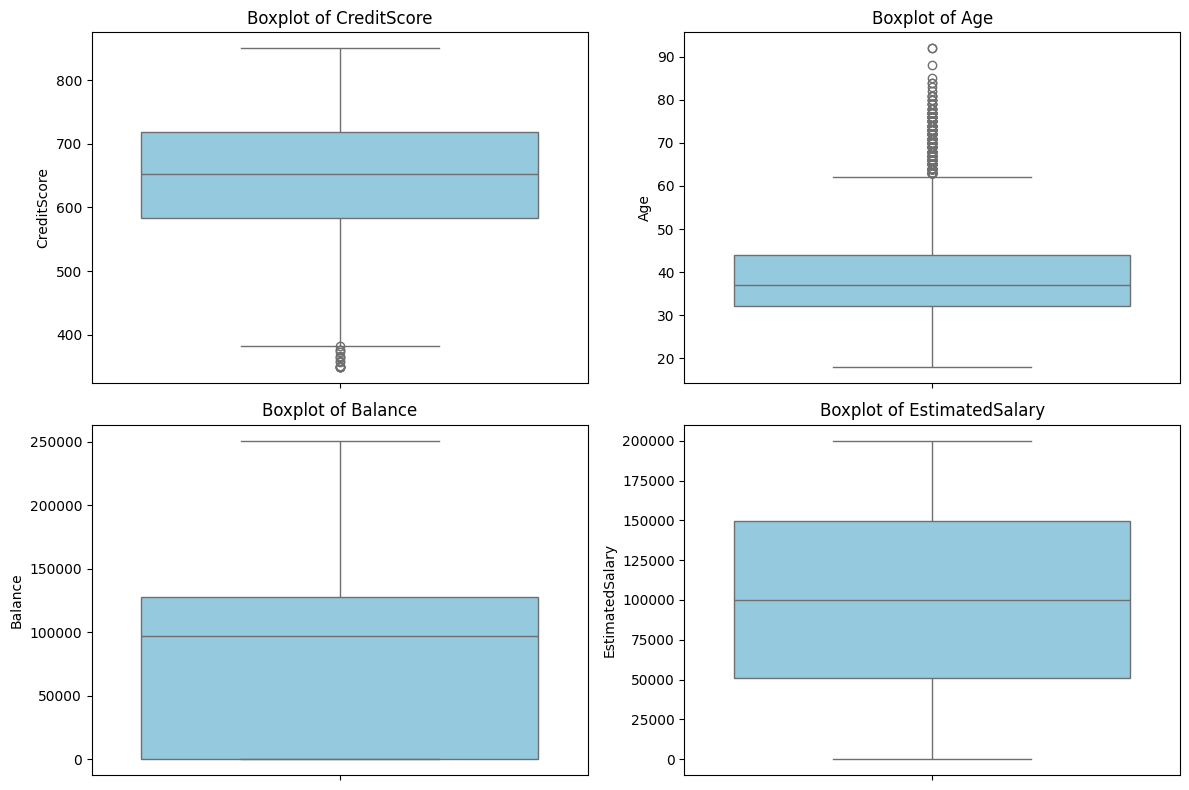

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.boxplot(data=df, y='CreditScore', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Boxplot of CreditScore')

sns.boxplot(data=df, y='Age', ax=axes[0,1], color='skyblue')
axes[0,1].set_title('Boxplot of Age')

sns.boxplot(data=df, y='Balance', ax=axes[1,0], color='skyblue')
axes[1,0].set_title('Boxplot of Balance')

sns.boxplot(data=df, y='EstimatedSalary', ax=axes[1,1], color='skyblue')
axes[1,1].set_title('Boxplot of EstimatedSalary')

plt.tight_layout()
plt.show()

---

### **Exploratory Data Analysis**
- **The goal of EDA is to better understand the distributions of features, identify trends or patterns, and explore relationships between features and the target variable (Exited)**



#### **Univariate Analysis**

In [ ]:
df['CreditScore'].describe()

,CreditScore
count,10000.000000
mean,650.528800
std,96.653299
min,350.000000
25%,584.000000
50%,652.000000
75%,718.000000
max,850.000000


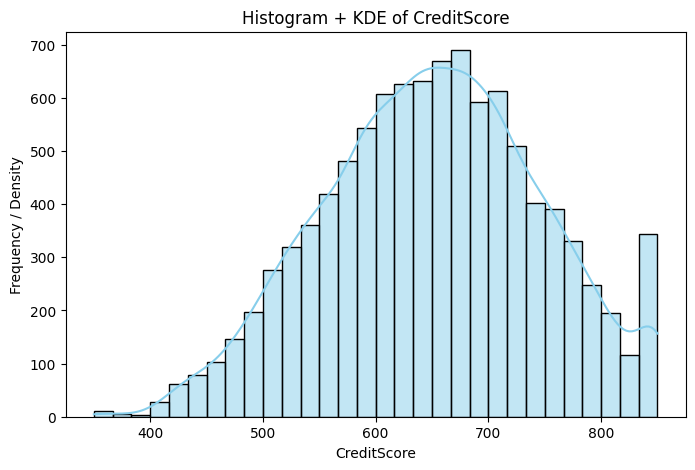

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['CreditScore'], bins=30, kde=True, color='skyblue', edgecolor='black')

plt.title("Histogram + KDE of CreditScore")
plt.xlabel("CreditScore")
plt.ylabel("Frequency / Density")
plt.show()

- The **distribution of credit scores** is slightly **right-skewed**, indicating that a larger proportion of customers have **higher credit scores** (closer to `800`).
- This suggests that **most customers maintain a strong credit history**, which could positively influence their likelihood of staying with the bank.



In [ ]:
df['Geography'].value_counts()

,count
Geography,
France,5014
Germany,2509
Spain,2477


/tmp/ipython-input-2145447843.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


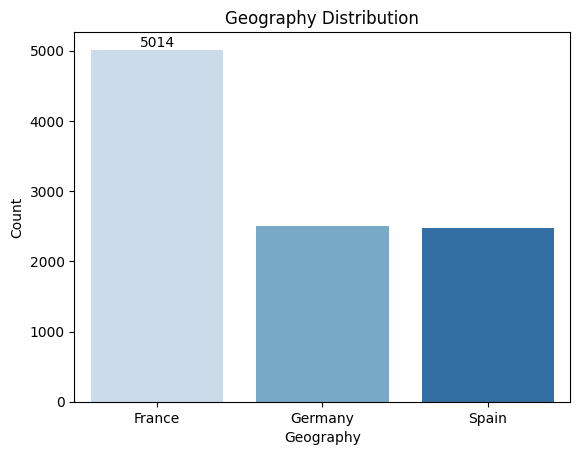

In [ ]:
palette = sns.color_palette("Blues", 3)

ax = sns.barplot(
    x=df['Geography'].value_counts().index,
    y=df['Geography'].value_counts().values,
    palette=palette
)

plt.title('Geography Distribution')
plt.xlabel("Geography")
plt.ylabel("Count")

ax.bar_label(ax.containers[0])

plt.show()

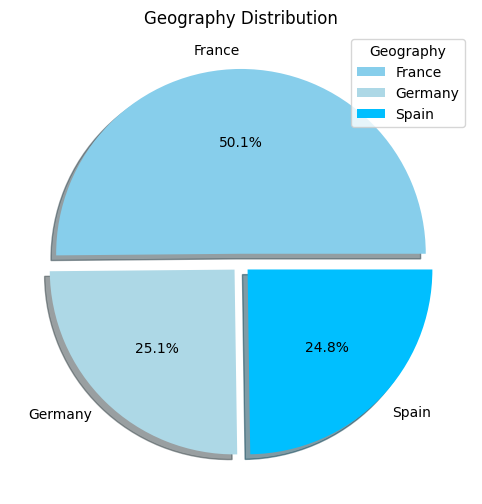

In [ ]:
plt.figure(figsize=(8, 6))
plt.pie(
    x=df['Geography'].value_counts(),
    labels=df['Geography'].value_counts().index,
    autopct="%1.1f%%",
    colors=['skyblue', 'lightblue', 'deepskyblue'],
    explode=[0.05, 0.05, 0.05],
    shadow=True
)
plt.title('Geography Distribution')
plt.legend(title="Geography")
plt.show()

In [ ]:
df['Gender'].value_counts()

,count
Gender,
Male,5457
Female,4543


In [ ]:
df['Gender'].value_counts(normalize=True) * 100

,proportion
Gender,
Male,54.57
Female,45.43


/tmp/ipython-input-3778541008.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


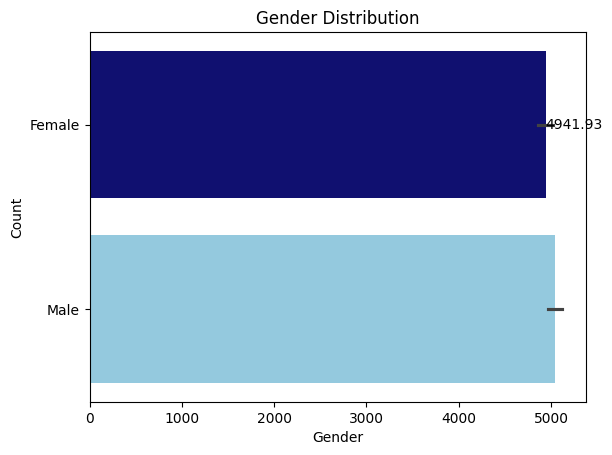

In [ ]:
ax = sns.barplot(
    x=df['Gender'].index,
    y=df['Gender'].values,
    palette=['navy', 'skyblue'])

plt.title('Gender Distribution')
plt.xlabel("Gender")
plt.ylabel("Count")
ax.bar_label(ax.containers[0])
plt.show()

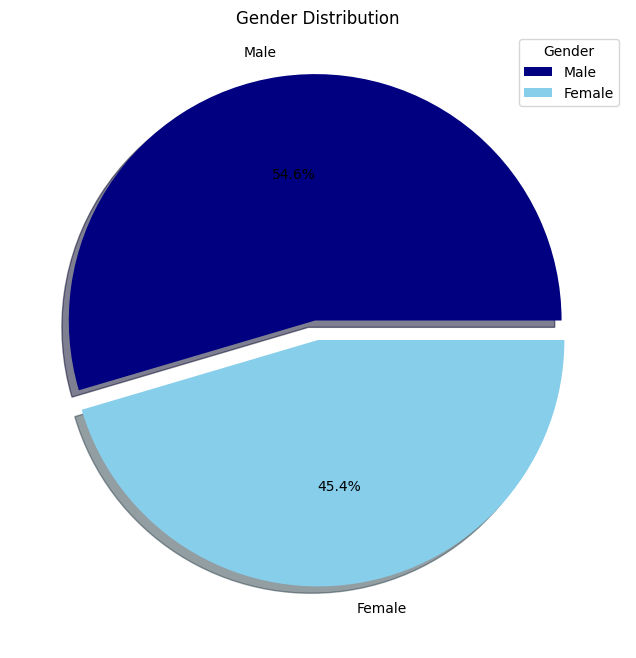

In [ ]:
plt.figure(figsize=(10, 8))
plt.pie(
    x=df['Gender'].value_counts(),
    labels=df['Gender'].value_counts().index,
    autopct="%1.1f%%",
    colors=['navy', 'skyblue'],
    explode=[0.08, 0],
    shadow=True
)
plt.title('Gender Distribution')
plt.legend(title="Gender")
plt.show()

In [ ]:
df['Age'].describe()

,Age
count,10000.000000
mean,38.921800
std,10.487806
min,18.000000
25%,32.000000
50%,37.000000
75%,44.000000
max,92.000000


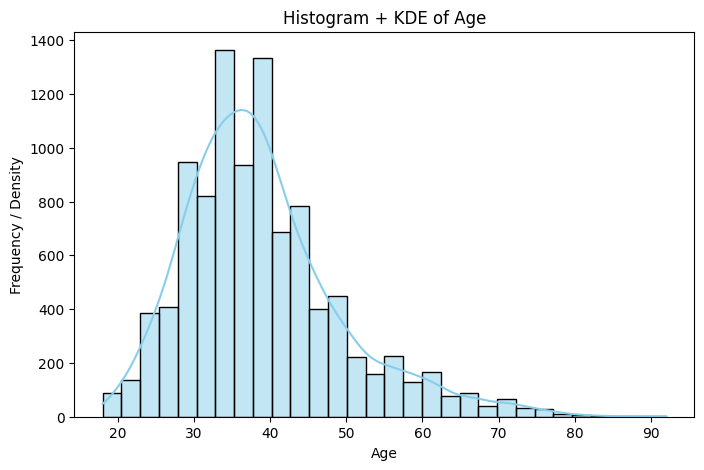

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['Age'], bins=30, kde=True, color='skyblue', edgecolor='black')

plt.title("Histogram + KDE of Age")
plt.xlabel("Age")
plt.ylabel("Frequency / Density")
plt.show()

- The age distribution is concentrated around 30–50 years, with fewer customers in the older age range.
- This suggests that most customers are middle-aged, which might be relevant depending on the bank’s target demographic.

In [ ]:
df['Tenure'].value_counts()

,count
Tenure,
2,1048
1,1035
7,1028
8,1025
5,1012
3,1009
4,989
9,984
6,967


/tmp/ipython-input-2060026170.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


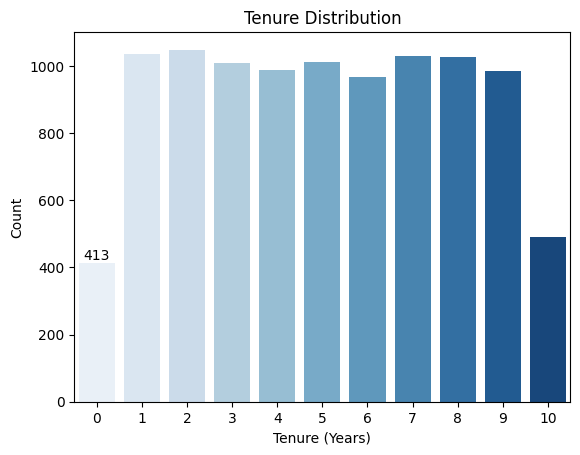

In [ ]:
tenure_counts = df['Tenure'].value_counts().sort_index()

ax = sns.barplot(
    x=tenure_counts.index,
    y=tenure_counts.values,
    palette=sns.color_palette("Blues", len(tenure_counts))
)

plt.title('Tenure Distribution')
plt.xlabel("Tenure (Years)")
plt.ylabel("Count")
ax.bar_label(ax.containers[0])
plt.show()

- The uniform distribution suggests that the bank has a balanced customer base across different tenure lengths.

In [ ]:
df['Balance'].describe()

,Balance
count,10000.000000
mean,76485.889288
std,62397.405202
min,0.000000
25%,0.000000
50%,97198.540000
75%,127644.240000
max,250898.090000


<Figure size 800x500 with 0 Axes>

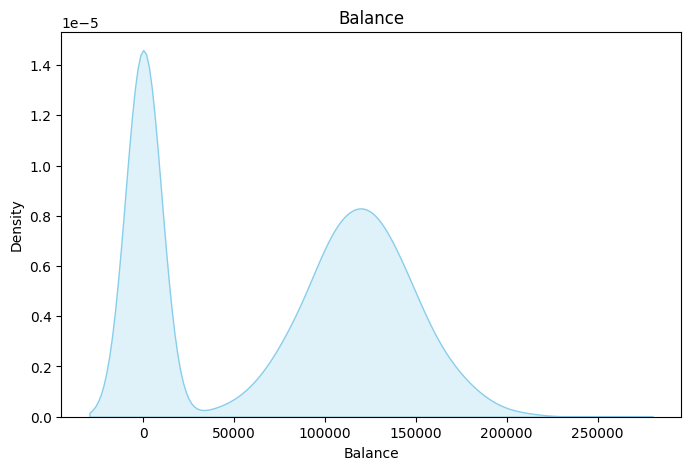

In [ ]:
plt.figure(figsize=(8,5))
plt.figure(figsize=(8,5))
sns.kdeplot(df['Balance'], color='skyblue', fill=True)

plt.title("Balance")
plt.xlabel("Balance")
plt.ylabel("Density")
plt.show()

- A bimodal distribution in the Balance column suggests two distinct customer segments:
  - Low-balance customers who may be more likely to churn.
  - High-balance customers who are likely more engaged and loyal.

In [ ]:
df['NumOfProducts'].value_counts()

,count
NumOfProducts,
1,5084
2,4590
3,266
4,60


/tmp/ipython-input-627541731.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


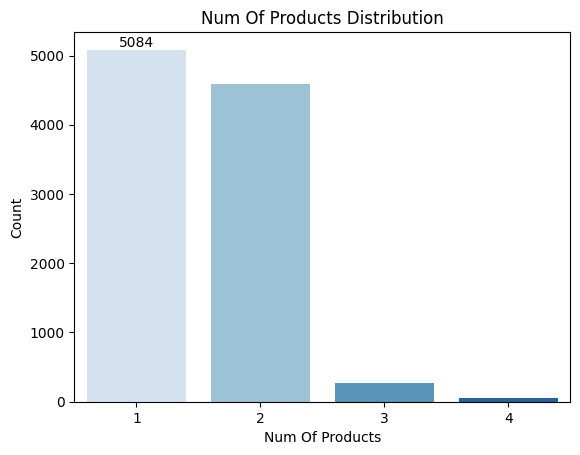

In [ ]:
num_products_counts = df['NumOfProducts'].value_counts().sort_index()

ax = sns.barplot(
    x=num_products_counts.index,
    y=num_products_counts.values,
    palette=sns.color_palette("Blues", len(num_products_counts))
)

plt.title('Num Of Products Distribution')
plt.xlabel("Num Of Products")
plt.ylabel("Count")
ax.bar_label(ax.containers[0])
plt.show()

In [ ]:
df['HasCrCard'].value_counts()

,count
HasCrCard,
1,7055
0,2945


/tmp/ipython-input-1941871692.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


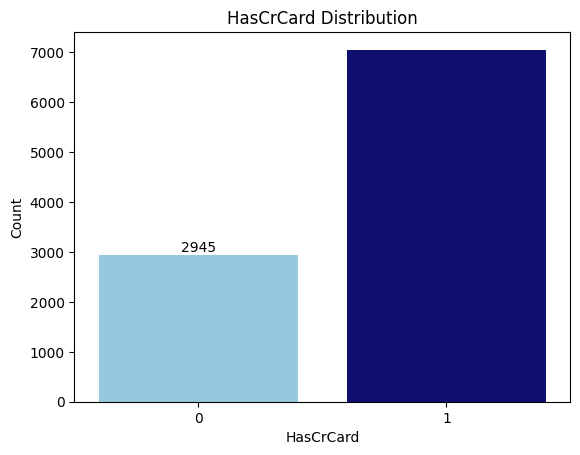

In [ ]:
has_cr_card_counts = df['HasCrCard'].value_counts().sort_index()

ax = sns.barplot(
    x=has_cr_card_counts.index,
    y=has_cr_card_counts.values,
    palette=['skyblue', 'navy']
)

plt.title('HasCrCard Distribution')
plt.xlabel("HasCrCard")
plt.ylabel("Count")
ax.bar_label(ax.containers[0])
plt.show()

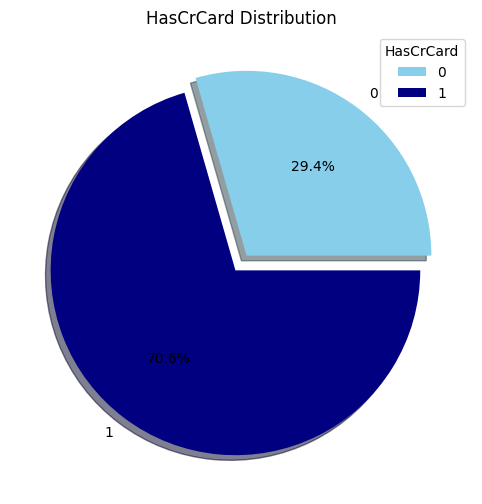

In [ ]:
has_cr_card_counts = df['HasCrCard'].value_counts().sort_index()

plt.figure(figsize=(8,6))
plt.pie(
    x=has_cr_card_counts,
    labels=has_cr_card_counts.index,
    autopct="%1.1f%%",
    colors=['skyblue', 'navy'],
    explode=[0.05, 0.05],
    shadow=True
)
plt.title('HasCrCard Distribution')
plt.legend(title="HasCrCard")
plt.show()

In [ ]:
df['IsActiveMember'].value_counts()

,count
IsActiveMember,
1,5151
0,4849


/tmp/ipython-input-4277677255.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


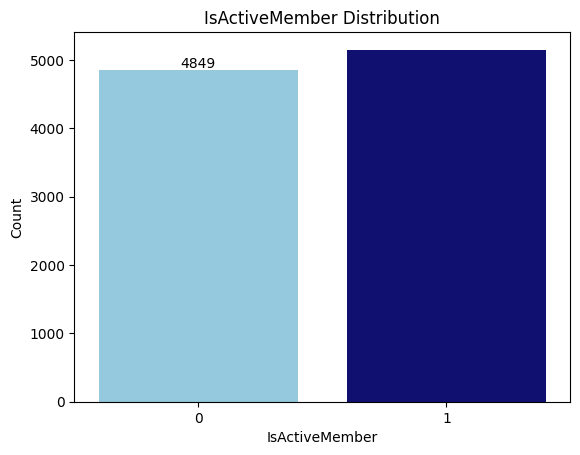

In [ ]:
active_member_counts = df['IsActiveMember'].value_counts().sort_index()

ax = sns.barplot(
    x=active_member_counts.index,
    y=active_member_counts.values,
    palette=['skyblue', 'navy']
)

plt.title('IsActiveMember Distribution')
plt.xlabel("IsActiveMember")
plt.ylabel("Count")
ax.bar_label(ax.containers[0])
plt.show()

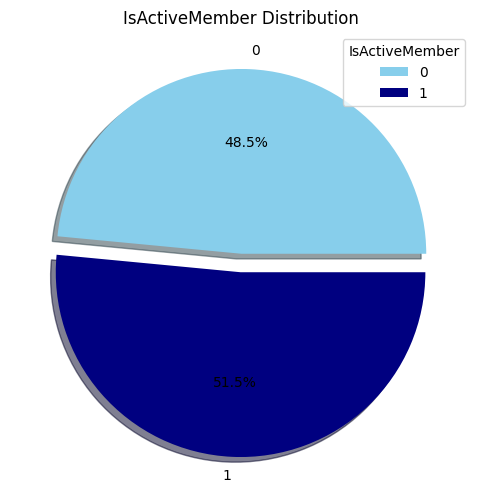

In [ ]:
active_member_counts = df['IsActiveMember'].value_counts().sort_index()

plt.figure(figsize=(8,6))
plt.pie(
    x=active_member_counts,
    labels=active_member_counts.index,
    autopct="%1.1f%%",
    colors=['skyblue', 'navy'],
    explode=[0.05, 0.05],
    shadow=True
)
plt.title('IsActiveMember Distribution')
plt.legend(title="IsActiveMember")
plt.show()

In [ ]:
df['EstimatedSalary'].describe()

,EstimatedSalary
count,10000.000000
mean,100090.239881
std,57510.492818
min,11.580000
25%,51002.110000
50%,100193.915000
75%,149388.247500
max,199992.480000


<Figure size 800x500 with 0 Axes>

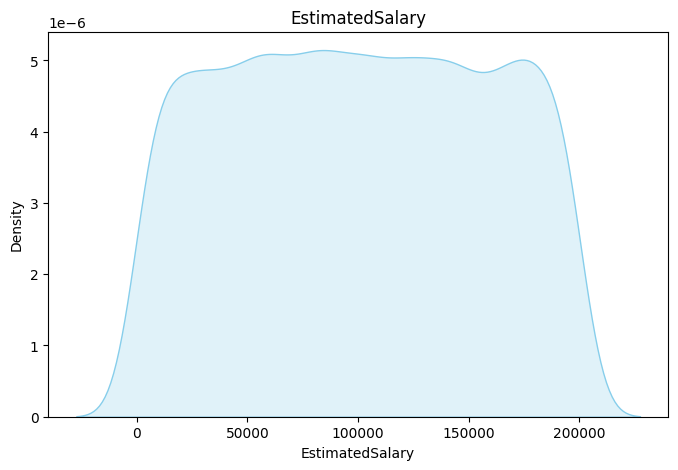

In [ ]:
plt.figure(figsize=(8,5))
plt.figure(figsize=(8,5))
sns.kdeplot(df['EstimatedSalary'], color='skyblue', fill=True)

plt.title("EstimatedSalary")
plt.xlabel("EstimatedSalary")
plt.ylabel("Density")
plt.show()

In [ ]:
df['Exited'].value_counts()

,count
Exited,
0,7963
1,2037


/tmp/ipython-input-1672611396.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


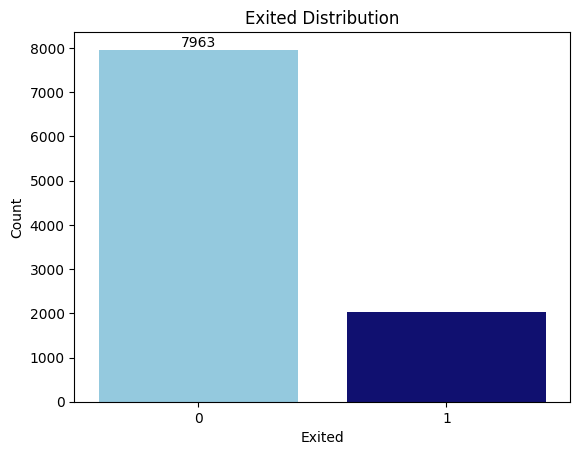

In [ ]:
exited_counts = df['Exited'].value_counts().sort_index()

ax = sns.barplot(
    x=exited_counts.index,
    y=exited_counts.values,
    palette=['skyblue', 'navy']
)

plt.title('Exited Distribution')
plt.xlabel("Exited")
plt.ylabel("Count")
ax.bar_label(ax.containers[0])
plt.show()

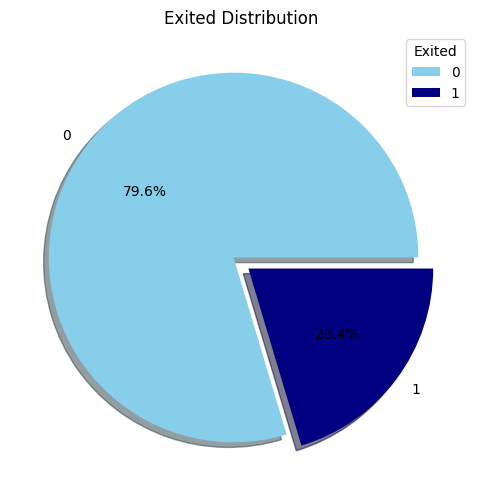

In [ ]:
exited_counts = df['Exited'].value_counts().sort_index()

plt.figure(figsize=(8,6))
plt.pie(
    x=exited_counts,
    labels=exited_counts.index,
    autopct="%1.1f%%",
    colors=['skyblue', 'navy'],
    explode=[0.05, 0.05],
    shadow=True
)
plt.title('Exited Distribution')
plt.legend(title="Exited")
plt.show()

---

#### **Bivariate Analysis**


##### **Numerical Features vs. Churn (Exited)**

/tmp/ipython-input-2662496260.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Exited', y=col, data=df, palette=['skyblue','navy'])
/tmp/ipython-input-2662496260.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Exited', y=col, data=df, palette=['skyblue','navy'])
/tmp/ipython-input-2662496260.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Exited', y=col, data=df, palette=['skyblue','navy'])
/tmp/ipython-input-2662496260.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v

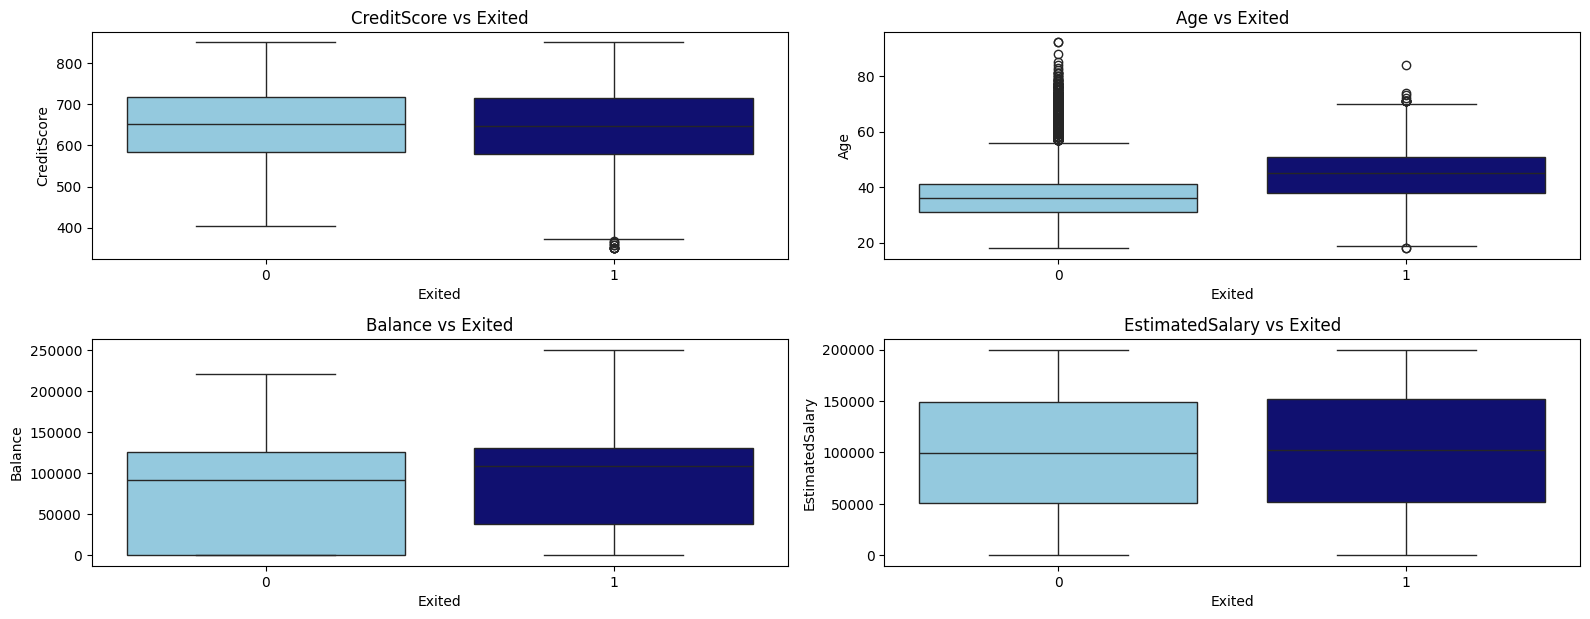

In [ ]:
numeric_cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

plt.figure(figsize=(16,12))

for i, col in enumerate(numeric_cols):
    plt.subplot(4, 2, i+1)
    sns.boxplot(x='Exited', y=col, data=df, palette=['skyblue','navy'])
    plt.title(f'{col} vs Exited')

plt.tight_layout()
plt.show()

##### **Categorical Features vs. Churn (Exited)**

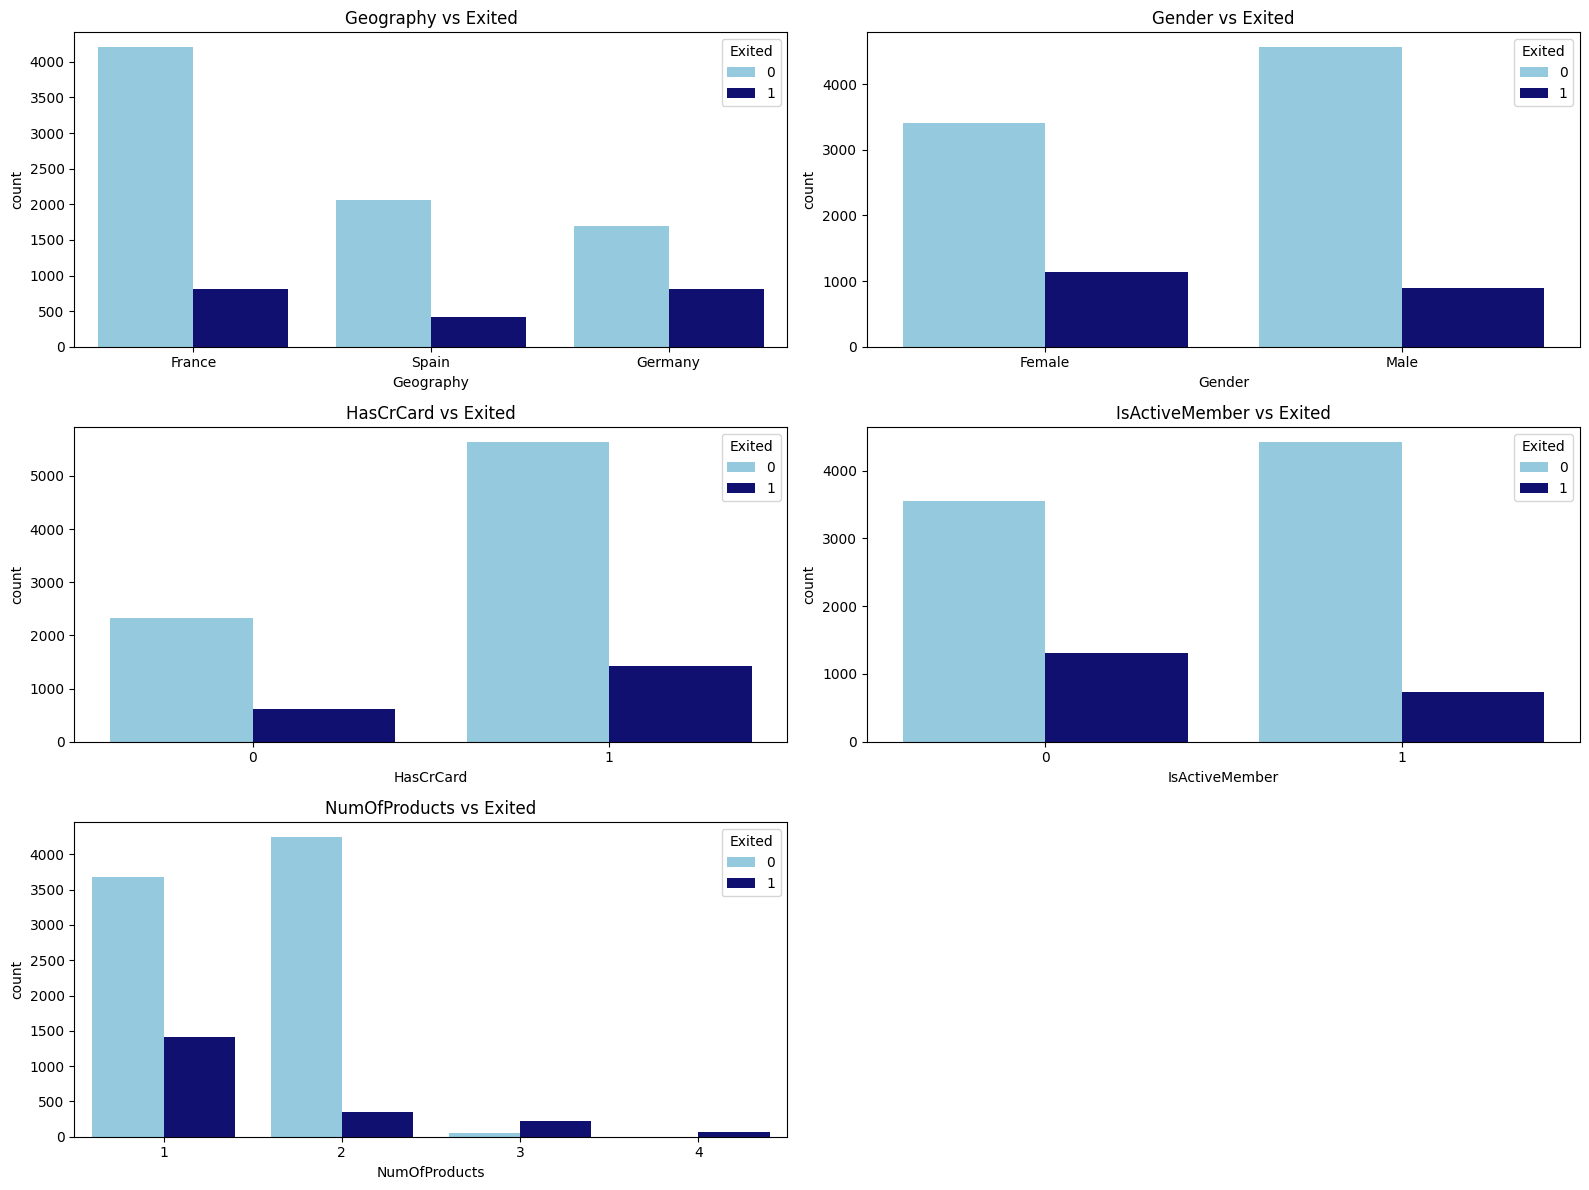

In [ ]:
categorical_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts']

plt.figure(figsize=(16,12))

for i, col in enumerate(categorical_cols):
    plt.subplot(3, 2, i+1)
    sns.countplot(x=col, hue='Exited', data=df, palette=['skyblue','navy'])
    plt.title(f'{col} vs Exited')

plt.tight_layout()
plt.show()

#### **Multivariate Analysis**

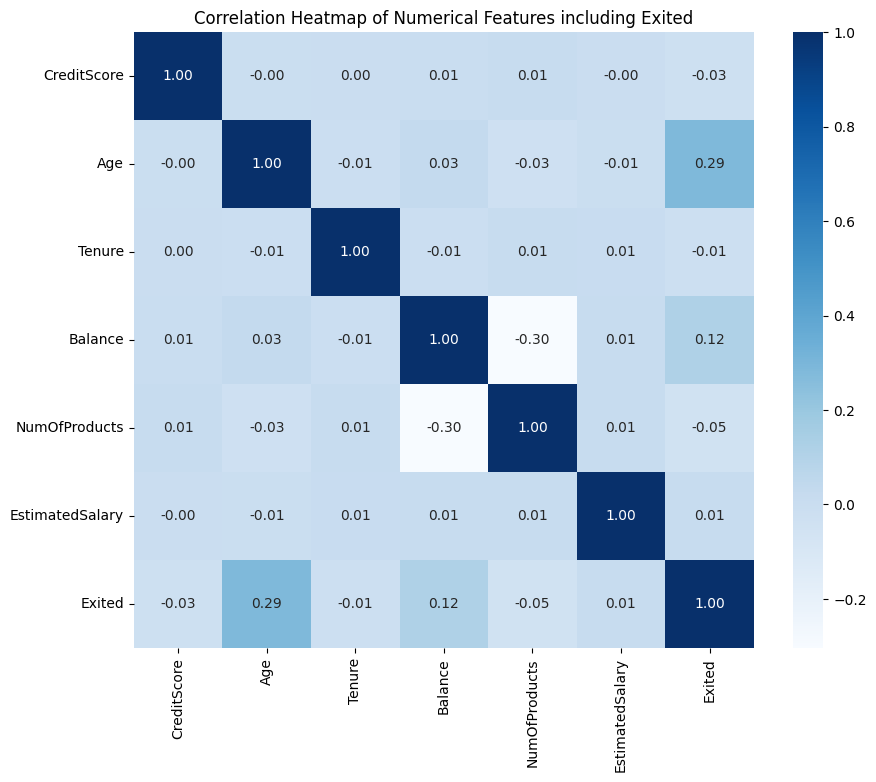

In [ ]:
numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Exited']

plt.figure(figsize=(10,8))
corr = df[numeric_cols].corr()

sns.heatmap(corr, annot=True, cmap='Blues', fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features including Exited")
plt.show()

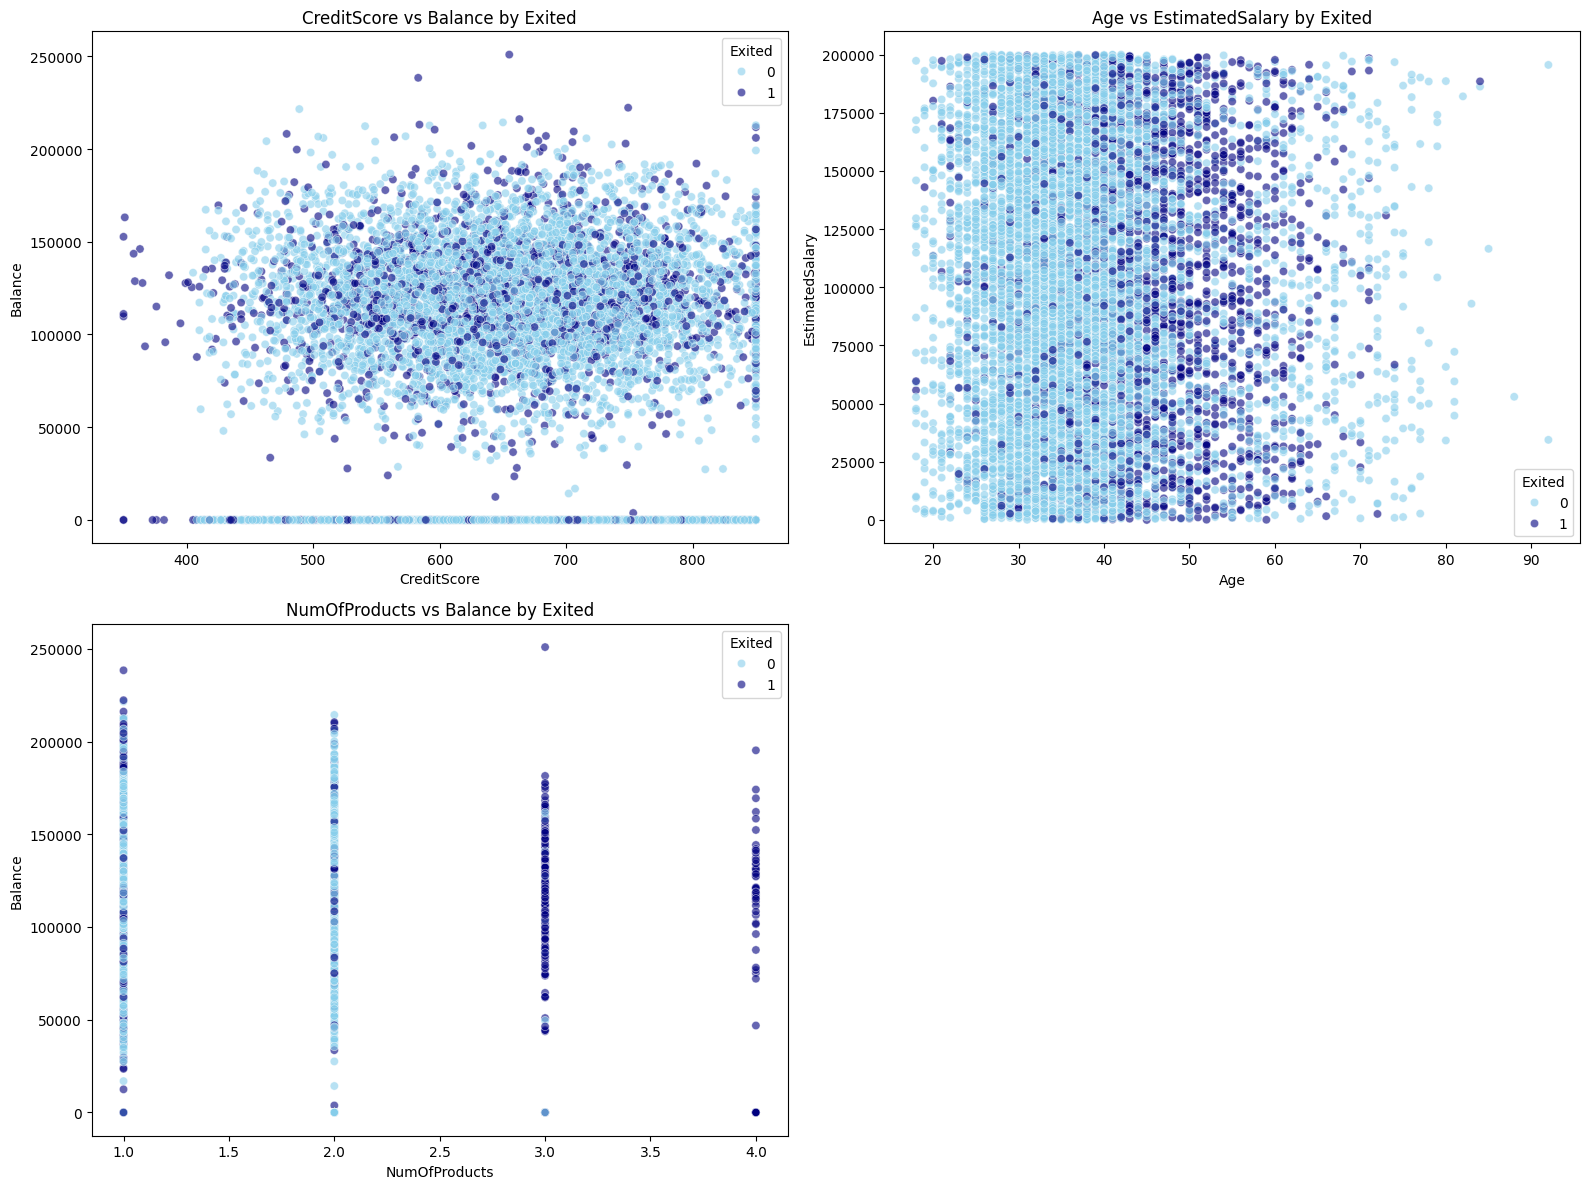

In [ ]:
plt.figure(figsize=(16,12))
num_pairs = [('CreditScore','Balance'), ('Age','EstimatedSalary'), ('NumOfProducts','Balance')]

for i, (x_col, y_col) in enumerate(num_pairs):
    plt.subplot(2,2,i+1)
    sns.scatterplot(data=df, x=x_col, y=y_col, hue='Exited', palette=['skyblue','navy'], alpha=0.6)
    plt.title(f'{x_col} vs {y_col} by Exited')

plt.tight_layout()
plt.show()

### **Data Preprocessing**

#### **Split to train and test**

In [ ]:
## To features and target
X = df.drop(columns=['Exited'], axis=1)
y = df['Exited']

## Split to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=45, stratify=y)

In [ ]:
## Check shapes
print('X_train.shape \t', X_train.shape)
print('y_train.shape \t', y_train.shape)
print('-----'*10)
print('X_test.shape \t', X_test.shape)
print('y_test.shape \t', y_test.shape)

X_train.shape 	 (8000, 10)
y_train.shape 	 (8000,)
--------------------------------------------------
X_test.shape 	 (2000, 10)
y_test.shape 	 (2000,)


#### **Class Distribution for Whole, Train, and Test Sets**

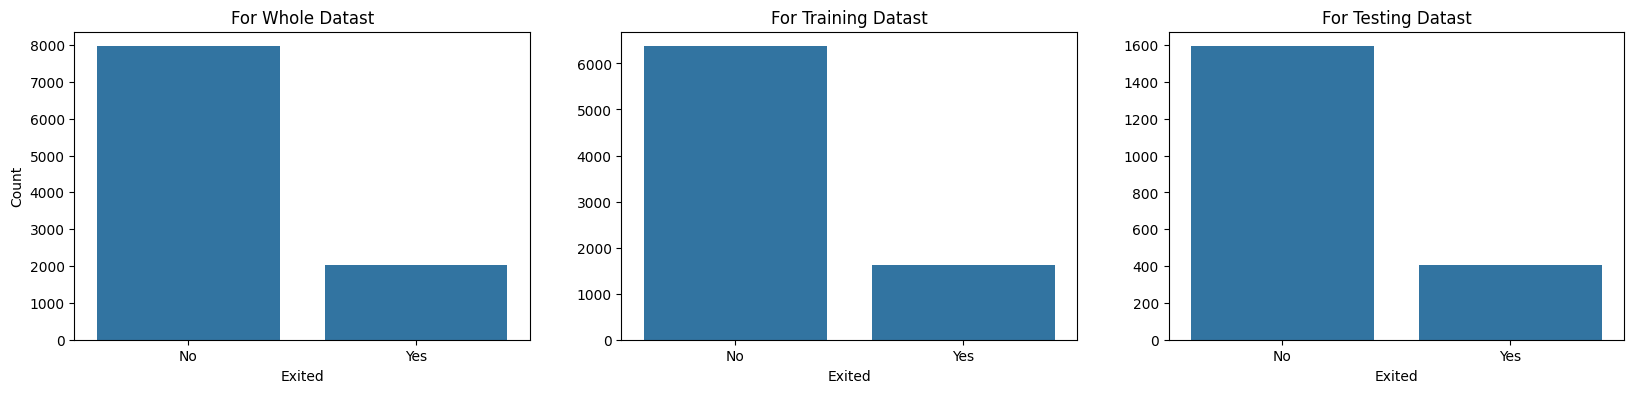

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

## Whole dataset
plt.sca(ax[0])
sns.countplot(x=y)
plt.title('For Whole Datast')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])

## train
plt.sca(ax[1])
sns.countplot(x=y_train)
plt.title('For Training Datast')
plt.ylabel('')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])

## test
plt.sca(ax[2])
sns.countplot(x=y_test)
plt.title('For Testing Datast')
plt.ylabel('')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

#### **Data Preprocessing & Pipeline**

In [ ]:
## Slice the lists
num_cols = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']
categ_cols = ['Gender', 'Geography']

ready_cols = list(set(X_train.columns.tolist()) - set(num_cols) - set(categ_cols))

In [ ]:
## Pipeline

## Numerical: num_cols --> Imputing using median, and standardscaler
## Categorical: categ_cols ---> Imputing using mode, and OHE
## Ready_cols ---> Imputing mode

## For Numerical
num_pipeline = Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='median')),
                    ('scaler', StandardScaler())
                ])

## For Categorical
categ_pipeline = Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='most_frequent')),
                    ('ohe', OneHotEncoder(drop='first', sparse_output=False))
                ])

## For ready cols
ready_pipeline = Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='most_frequent'))
                ])



## Combine all pipelines
all_pipeline = ColumnTransformer(transformers=[
                ('numerical', num_pipeline, num_cols),
                ('categorical', categ_pipeline, categ_cols),
                ('ready', ready_pipeline, ready_cols)
            ])


## fit and apply
all_pipeline.fit_transform(X_train)
X_train_final =  all_pipeline.transform(X_train)
X_test_final = all_pipeline.transform(X_test)

In [ ]:
## Check train
X_train_final.shape, y_train.shape

((8000, 11), (8000,))

In [ ]:
## Check test
X_test_final.shape, y_test.shape

((2000, 11), (2000,))

In [ ]:
## Create a folder for the models and any needed pipelines
ASSETS_FOLDER_PATH = os.path.join(os.getcwd(), 'assets')
os.makedirs(ASSETS_FOLDER_PATH, exist_ok=True)

In [ ]:
## Dump the combined pipeline
joblib.dump(all_pipeline, os.path.join(ASSETS_FOLDER_PATH, 'preprocessor.pkl'))

['/content/assets/preprocessor.pkl']

### **Machine Learning Models**

#### **Logistic Regression model(Class Weights)**

In [ ]:
## 2. prepare class_weights for solving imbalance dataset
vals_count = 1 - (np.bincount(y_train) / len(y_train))
vals_count = vals_count / np.sum(vals_count)  ## normalizing
vals_count

dict_weights = {}
for i in range(2):  ## 2 classes (0, 1)
    dict_weights[i] = vals_count[i]

## to model
dict_weights

{0: np.float64(0.20375), 1: np.float64(0.79625)}

In [ ]:
## 1. Using logisitic --> with considering the imabalancing data using class_weights
log_clf = LogisticRegression(C=1.5, max_iter=10000, penalty='l2', class_weight=dict_weights)
log_clf.fit(X_train_final, y_train)

## Predict and evaluate
y_pred_train_log_cls = log_clf.predict(X_train_final)
y_pred_test_log_cls = log_clf.predict(X_test_final)

## Using f1_score
score_train_log = f1_score(y_train, y_pred_train_log_cls)
score_test_log = f1_score(y_test, y_pred_test_log_cls)

print(f'The f1_score using Logistic model for Training Dataset with class_weigths is: {score_train_log*100:.3f} %')
print(f'The f1_score using Logistic model for Testing Dataset with class_weigths is: {score_test_log*100:.3f} %')

The f1_score using Logistic model for Training Dataset with class_weigths is: 50.011 %
The f1_score using Logistic model for Testing Dataset with class_weigths is: 48.339 %


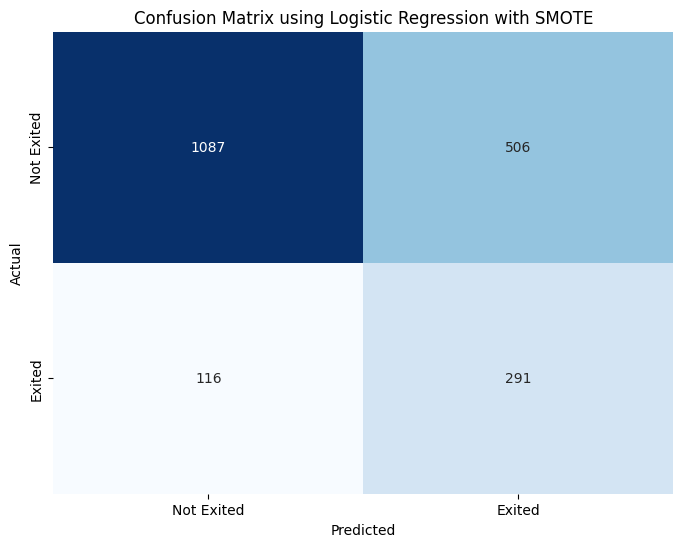

In [ ]:
## Confusion Matrix using Logistic Regression with Class Weights
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_test_log_cls), annot=True, cbar=False,
            fmt='d', cmap='Blues', xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix using Logistic Regression with SMOTE')
plt.show()

#### **Logistic Regression model(SMOTE)**

In [ ]:
## 3. Using SMOTE for over sampling --> Apply only on train data
over = SMOTE(sampling_strategy=0.7)
X_train_resmapled, y_train_resampled = over.fit_resample(X_train_final, y_train)

In [ ]:
## Shape of Train Data after resamples
X_train_resmapled.shape, y_train_resampled.shape

((10829, 11), (10829,))

In [ ]:
y_train_resampled.value_counts()   ## Nice ~ 0.7

,count
Exited,
0,6370
1,4459


In [ ]:
## 3. Using logisitic --> with considering the imabalancing data using oversampled data (SMOTE)
log_clf = LogisticRegression(C=1.5, max_iter=10000, penalty='l2')
log_clf.fit(X_train_resmapled, y_train_resampled)

## Predict and evaluate
y_pred_train_log_smote = log_clf.predict(X_train_final)
y_pred_test_log_smote = log_clf.predict(X_test_final)

## Using f1_score
score_train_log = f1_score(y_train, y_pred_train_log_smote)
score_test_log = f1_score(y_test, y_pred_test_log_smote)

print(f'The f1_score using Logistic model for Training Dataset with SMOTE is: {score_train_log*100:.3f} %')
print(f'The f1_score using Logistic model for Testing Dataset with SMOTE is: {score_test_log*100:.3f} %')

The f1_score using Logistic model for Training Dataset with SMOTE is: 49.743 %
The f1_score using Logistic model for Testing Dataset with SMOTE is: 48.083 %


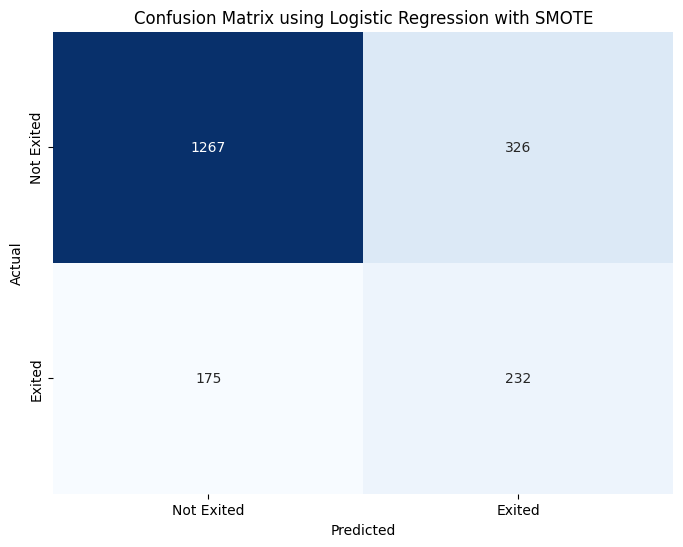

In [ ]:
## Confusion Matrix using Logistic Regression with SMOTE
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_test_log_smote), annot=True, cbar=False,
            fmt='d', cmap='Blues', xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix using Logistic Regression with SMOTE')
plt.show()

#### **SVC Model**

##### **Using OverSampled(SMOTE)**

In [ ]:
## 3. Using SVC --> with considering the imbalancing data using oversampled data (SMOTE)
svc_clf = SVC(C=1.5, kernel='rbf', probability=True)  # استخدمت RBF kernel كخيار شائع
svc_clf.fit(X_train_resmapled, y_train_resampled)

SVC(C=1.5, probability=True)

In [ ]:
## Predict and evaluate
y_pred_train_svc = svc_clf.predict(X_train_resmapled)
y_pred_test_svc = svc_clf.predict(X_test_final)

In [ ]:
## Using f1_score
score_train_svc = f1_score(y_train_resampled, y_pred_train_svc)
score_test_svc = f1_score(y_test, y_pred_test_svc)

print(f'The f1_score using SVC model for Training Dataset with SMOTE is: {score_train_svc*100:.3f} %')
print(f'The f1_score using SVC model for Testing Dataset with SMOTE is: {score_test_svc*100:.3f} %')

The f1_score using SVC model for Training Dataset with SMOTE is: 72.186 %
The f1_score using SVC model for Testing Dataset with SMOTE is: 58.553 %


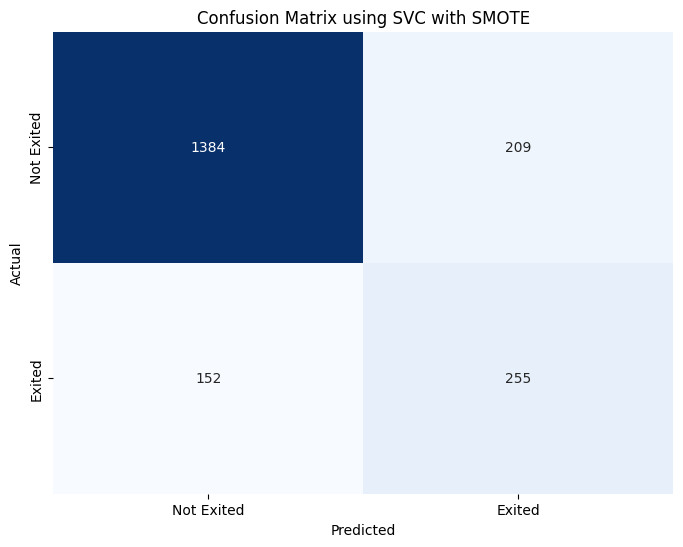

In [ ]:
## Confusion Matrix using SVC with SMOTE
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_test_svc), annot=True, cbar=False,
            fmt='d', cmap='Blues', xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix using SVC with SMOTE')
plt.show()

##### **Using Class Weights**

In [ ]:
## Using SVC --> with considering the imbalancing data using class_weights
svc_clf = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight=dict_weights,
    random_state=42
)
svc_clf.fit(X_train_final, y_train)

## Predict and evaluate
y_pred_train_svc_w = svc_clf.predict(X_train_final)
y_pred_test_svc_w = svc_clf.predict(X_test_final)

## Using f1_score
score_train_svc_w = f1_score(y_train, y_pred_train_svc_w)
score_test_svc_w = f1_score(y_test, y_pred_test_svc_w)

print(f'The f1_score using SVC model for Training Dataset with class_weights is: {score_train_svc_w*100:.3f} %')
print(f'The f1_score using SVC model for Testing Dataset with class_weights is: {score_test_svc_w*100:.3f} %')

The f1_score using SVC model for Training Dataset with class_weights is: 53.921 %
The f1_score using SVC model for Testing Dataset with class_weights is: 53.147 %


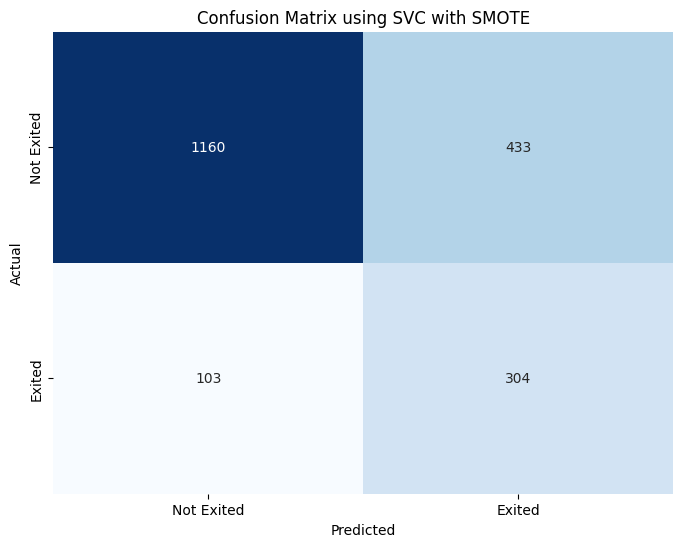

In [ ]:
## Confusion Matrix using SVC with SMOTE
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_test_svc_w), annot=True, cbar=False,
            fmt='d', cmap='Blues', xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix using SVC with SMOTE')
plt.show()

#### **Naive-Bayes Model**

In [ ]:
## Using Naive Bayes --> With considering the imabalancing data using oversampled data (SMOTE)
gauss_nb = GaussianNB()
gauss_nb.fit(X_train_resmapled, y_train_resampled)

## Predict and evaluate
y_pred_train_gauss_nb = gauss_nb.predict(X_train_final)
y_pred_test_gauss_nb = gauss_nb.predict(X_test_final)

## Using f1_score
score_train_gauss_nb = f1_score(y_train, y_pred_train_gauss_nb)
score_test_gauss_nb = f1_score(y_test, y_pred_test_gauss_nb)

print(f'The f1_score using Gaussian-NB model for Training Dataset with SMOTE is {score_train_gauss_nb*100:.3f} %')
print(f'The f1_score using Gaussian-NB model for Testing Dataset with SMOTE is {score_test_gauss_nb*100:.3f} %')

The f1_score using Gaussian-NB model for Training Dataset with SMOTE is 51.348 %
The f1_score using Gaussian-NB model for Testing Dataset with SMOTE is 48.632 %


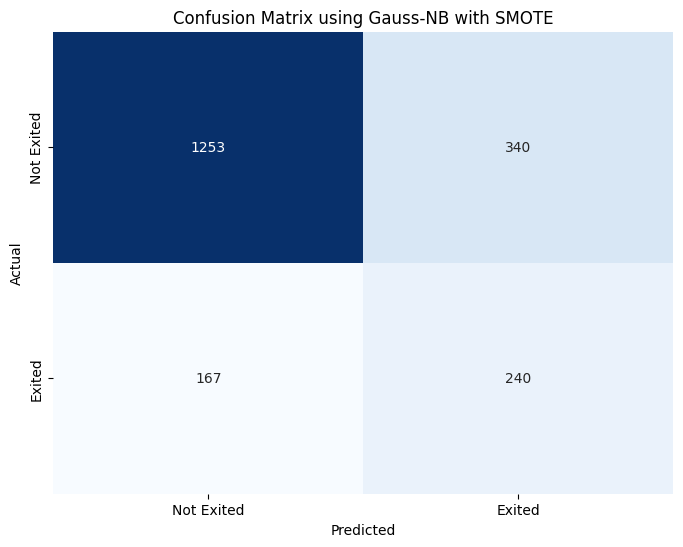

In [ ]:
## Confusion Matrix using NB with SMOTE
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_test_gauss_nb), annot=True, cbar=False,
            fmt='d', cmap='Blues', xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix using Gauss-NB with SMOTE')
plt.show()

#### **K-Neighbors Classifier**

In [ ]:
## Using KNN Classifier --> With considering the imabalancing data using oversampled data (SMOTE)
knn_clf = KNeighborsClassifier(n_neighbors=5)  # ممكن تغيّر عدد الجيران لو حابب
knn_clf.fit(X_train_resmapled, y_train_resampled)

## Predict and evaluate
y_pred_train_knn = knn_clf.predict(X_train_final)
y_pred_test_knn = knn_clf.predict(X_test_final)

## Using f1_score
score_train_knn = f1_score(y_train, y_pred_train_knn)
score_test_knn = f1_score(y_test, y_pred_test_knn)

print(f'The f1_score using KNN model for Training Dataset with SMOTE is {score_train_knn*100:.3f} %')
print(f'The f1_score using KNN model for Testing Dataset with SMOTE is {score_test_knn*100:.3f} %')

The f1_score using KNN model for Training Dataset with SMOTE is 73.952 %
The f1_score using KNN model for Testing Dataset with SMOTE is 51.120 %


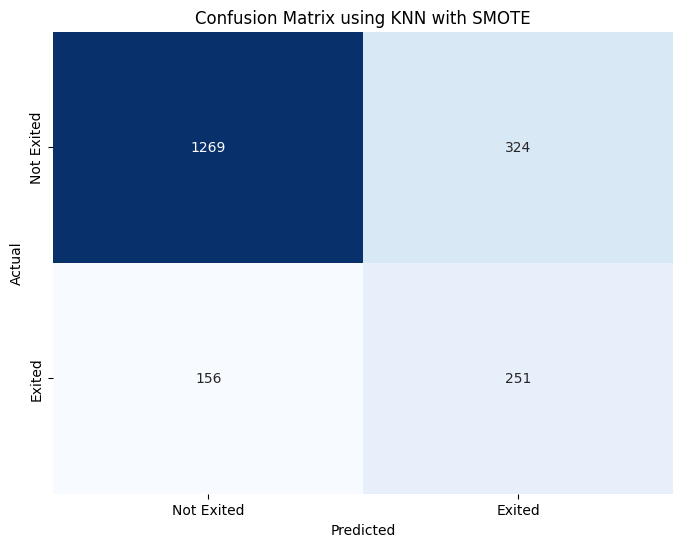

In [ ]:
## Confusion Matrix using KNN with SMOTE
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_test_knn), annot=True, cbar=False,
            fmt='d', cmap='Blues', xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix using KNN with SMOTE')
plt.show()

#### **Decision Tree Classifier**

In [ ]:
## Using Decision Tree Classifier --> With considering the imabalancing data using oversampled data (SMOTE)
dt_clf = DecisionTreeClassifier(max_depth=None, random_state=42)  # ممكن تضبط الـ max_depth أو تعمل tuning
dt_clf.fit(X_train_resmapled, y_train_resampled)

## Predict and evaluate
y_pred_train_dt = dt_clf.predict(X_train_final)
y_pred_test_dt = dt_clf.predict(X_test_final)

## Using f1_score
score_train_dt = f1_score(y_train, y_pred_train_dt)
score_test_dt = f1_score(y_test, y_pred_test_dt)

print(f'The f1_score using Decision Tree model for Training Dataset with SMOTE is {score_train_dt*100:.3f} %')
print(f'The f1_score using Decision Tree model for Testing Dataset with SMOTE is {score_test_dt*100:.3f} %')

The f1_score using Decision Tree model for Training Dataset with SMOTE is 100.000 %
The f1_score using Decision Tree model for Testing Dataset with SMOTE is 50.058 %


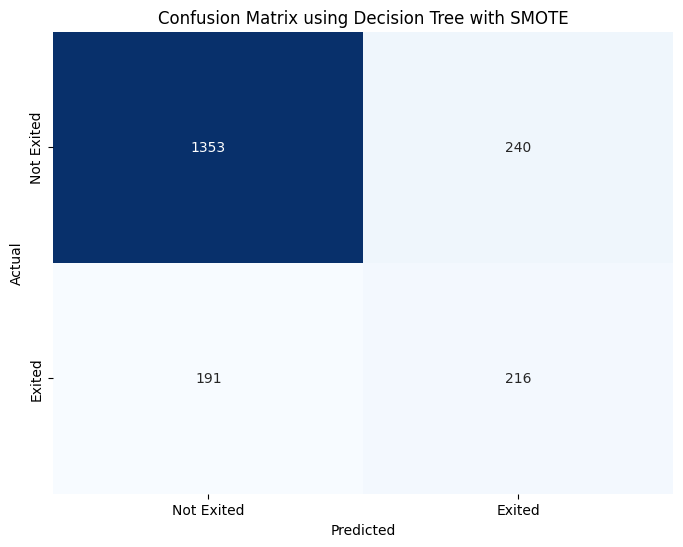

In [ ]:
## Confusion Matrix using Decision Tree with SMOTE
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_test_dt), annot=True, cbar=False,
            fmt='d', cmap='Blues', xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix using Decision Tree with SMOTE')
plt.show()

#### **RandomForestClassifier Model**

##### **Using Oversampled Data(SMOTE)**

In [ ]:
## Using Random Forest Classifier --> With considering the imabalancing data using oversampled data (SMOTE)
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42
)
rf_clf.fit(X_train_resmapled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [ ]:
## Predict and evaluate
y_pred_train_rf = rf_clf.predict(X_train_final)
y_pred_test_rf = rf_clf.predict(X_test_final)

## Using f1_score
score_train_rf = f1_score(y_train, y_pred_train_rf)
score_test_rf = f1_score(y_test, y_pred_test_rf)

print(f'The f1_score using Random Forest model for Training Dataset with SMOTE is {score_train_rf*100:.3f} %')
print(f'The f1_score using Random Forest model for Testing Dataset with SMOTE is {score_test_rf*100:.3f} %')

The f1_score using Random Forest model for Training Dataset with SMOTE is 100.000 %
The f1_score using Random Forest model for Testing Dataset with SMOTE is 59.198 %


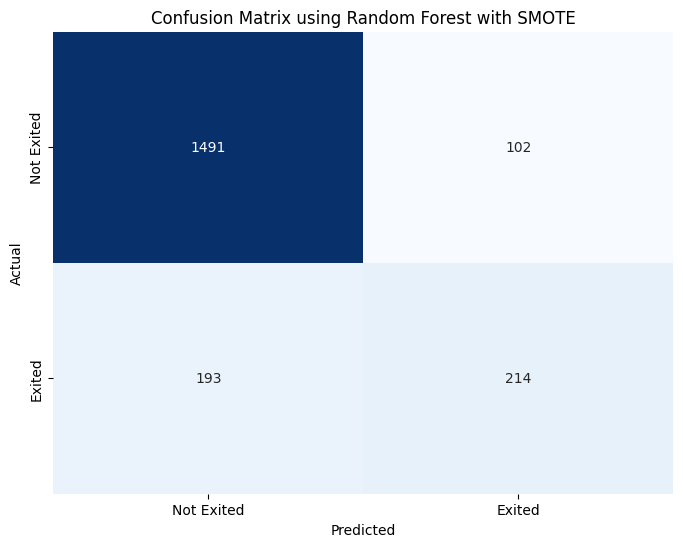

In [ ]:
## Confusion Matrix using Random Forest with SMOTE
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_test_rf), annot=True, cbar=False,
            fmt='d', cmap='Blues', xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix using Random Forest with SMOTE')
plt.show()

##### **Using Class Weights**

In [ ]:
## 1. Using RF --> with considering the imabalancing data using class_weights
forst_clf = RandomForestClassifier(n_estimators=150, max_depth=5, random_state=45, class_weight=dict_weights)
forst_clf.fit(X_train_final, y_train)

## Predict and evaluate
y_pred_train_forest = forst_clf.predict(X_train_final)
y_pred_test_foerst = forst_clf.predict(X_test_final)

## Using f1_score
score_train_forest = f1_score(y_train, y_pred_train_forest)
score_test_forest = f1_score(y_test, y_pred_test_foerst)

print(f'The f1_score using RF model for Training Dataset with class_weights is: {score_train_forest*100:.3f} %')
print(f'The f1_score using RF model for Testing Dataset with class_weights is: {score_test_forest*100:.3f} %')

The f1_score using RF model for Training Dataset with class_weights is: 60.225 %
The f1_score using RF model for Testing Dataset with class_weights is: 58.512 %


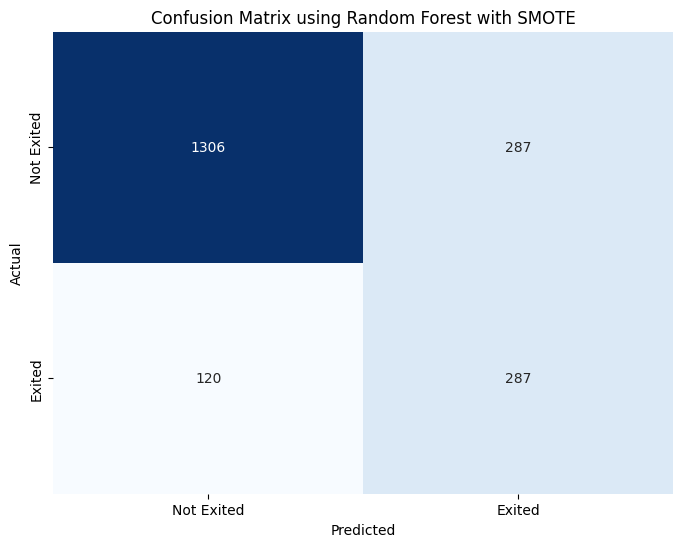

In [ ]:
## Confusion Matrix using Random Forest with SMOTE
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_test_foerst), annot=True, cbar=False,
            fmt='d', cmap='Blues', xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix using Random Forest with SMOTE')
plt.show()

#### **Bagging Classifier**

In [ ]:
## Using Bagging Classifier --> With considering the imabalancing data using oversampled data (SMOTE)
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100,
    max_samples=1.0,
    max_features=1.0,
    bootstrap=True,
    random_state=42
)
bagging_clf.fit(X_train_resmapled, y_train_resampled)

BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42),
                  n_estimators=100, random_state=42)

In [ ]:
## Predict and evaluate
y_pred_train_bagging = bagging_clf.predict(X_train_final)
y_pred_test_bagging = bagging_clf.predict(X_test_final)

## Using f1_score
score_train_bagging = f1_score(y_train, y_pred_train_bagging)
score_test_bagging = f1_score(y_test, y_pred_test_bagging)

print(f'The f1_score using Bagging Classifier for Training Dataset with SMOTE is {score_train_bagging*100:.3f} %')
print(f'The f1_score using Bagging Classifier for Testing Dataset with SMOTE is {score_test_bagging*100:.3f} %')

The f1_score using Bagging Classifier for Training Dataset with SMOTE is 100.000 %
The f1_score using Bagging Classifier for Testing Dataset with SMOTE is 55.882 %


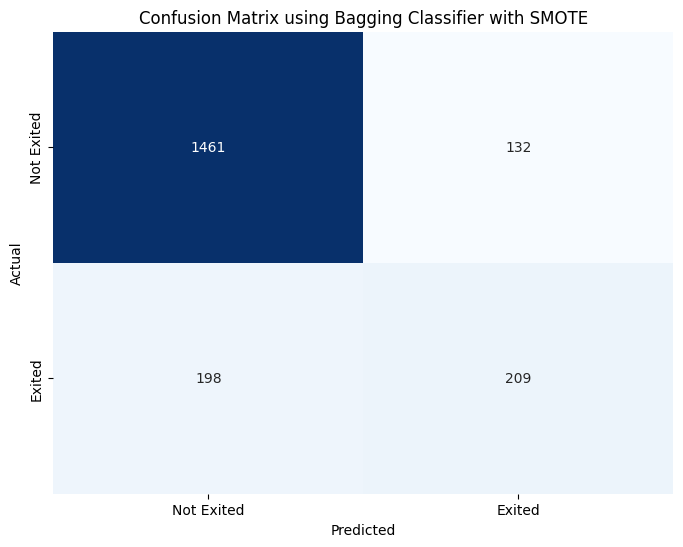

In [ ]:
## Confusion Matrix using Bagging Classifier with SMOTE
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_test_bagging), annot=True, cbar=False,
            fmt='d', cmap='Blues', xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix using Bagging Classifier with SMOTE')
plt.show()

#### **ExtraTreesClassifier**

In [ ]:
## Using ExtraTreesClassifier --> With considering the imbalancing data using oversampled data (SMOTE)
extra_trees_clf = ExtraTreesClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

extra_trees_clf.fit(X_train_resmapled, y_train_resampled)

ExtraTreesClassifier(random_state=42)

In [ ]:
## Predict and evaluate
y_pred_train_extra = extra_trees_clf.predict(X_train_final)
y_pred_test_extra = extra_trees_clf.predict(X_test_final)

## Using f1_score
score_train_extra = f1_score(y_train, y_pred_train_extra)
score_test_extra = f1_score(y_test, y_pred_test_extra)

print(f'The f1_score using ExtraTreesClassifier for Training Dataset with SMOTE is {score_train_extra*100:.3f} %')
print(f'The f1_score using ExtraTreesClassifier for Testing Dataset with SMOTE is {score_test_extra*100:.3f} %')

The f1_score using ExtraTreesClassifier for Training Dataset with SMOTE is 100.000 %
The f1_score using ExtraTreesClassifier for Testing Dataset with SMOTE is 55.794 %


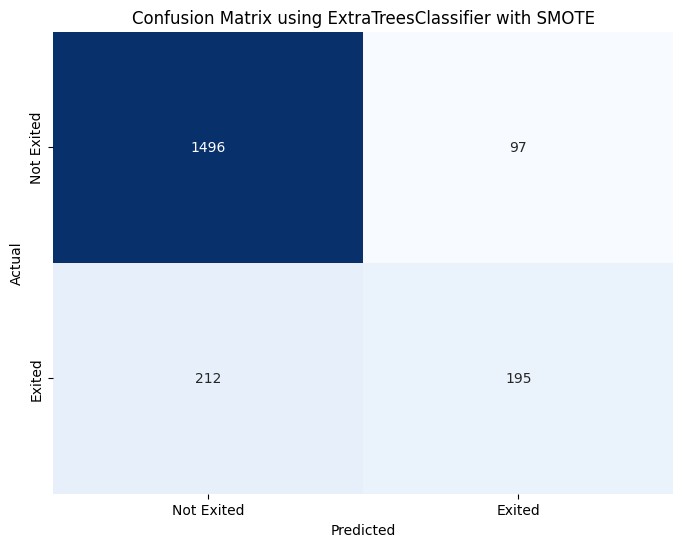

In [ ]:
## Confusion Matrix using ExtraTreesClassifier with SMOTE
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_test_extra), annot=True, cbar=False,
            fmt='d', cmap='Blues', xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix using ExtraTreesClassifier with SMOTE')
plt.show()

#### **Model Performance Comparison (f1-Score) Before Tunning**

In [ ]:
## Create lists for the f1-scores
train_scores = [
    score_train_log,
    score_train_svc,
    score_train_svc_w,
    score_train_gauss_nb,
    score_train_knn,
    score_train_dt,
    score_train_rf,
    score_train_forest,  # RF with class weights
    score_train_bagging,
    score_train_extra
]

test_scores = [
    score_test_log,
    score_test_svc,
    score_test_svc_w,
    score_test_gauss_nb,
    score_test_knn,
    score_test_dt,
    score_test_rf,
    score_test_forest,  # RF with class weights
    score_test_bagging,
    score_test_extra
]

## Create model names list
model_names = [
    'Logistic Regression (SMOTE)',
    'SVC (SMOTE)',
    'SVC (Class Weights)',
    'Gaussian Naive Bayes (SMOTE)',
    'KNN (SMOTE)',
    'Decision Tree (SMOTE)',
    'Random Forest (SMOTE)',
    'Random Forest (Class Weights)',
    'Bagging Classifier (SMOTE)',
    'ExtraTrees Classifier (SMOTE)'
]

## Create DataFrame
df_scores = pd.DataFrame({
    'Model': model_names,
    'Train f1-Score': train_scores,
    'Test f1-Score': test_scores
})

## Sort by Test f1-Score descending
df_scores = df_scores.sort_values(by='Test f1-Score', ascending=False)

## Display
print("### Model Comparison Table (Sorted by Test f1-Score):")
display(df_scores)

### Model Comparison Table (Sorted by Test f1-Score):


,Model,Train f1-Score,Test f1-Score
6,Random Forest (SMOTE),1.000000,0.591978
1,SVC (SMOTE),0.721860,0.585534
7,Random Forest (Class Weights),0.602249,0.585117
8,Bagging Classifier (SMOTE),1.000000,0.558824
9,ExtraTrees Classifier (SMOTE),1.000000,0.557940
2,SVC (Class Weights),0.539209,0.531469
4,KNN (SMOTE),0.739521,0.511202
5,Decision Tree (SMOTE),1.000000,0.500579
3,Gaussian Naive Bayes (SMOTE),0.513478,0.486322
0,Logistic Regression (SMOTE),0.497432,0.480829


#### **FineTunning Models Using GridSearchCV**

In [ ]:
## Using GridSearchCV for outperformed RF (RF with SMOTE)
forst_clf = RandomForestClassifier(n_estimators=150, max_depth=5, random_state=45)

## Your space to search --> Just a proof of concept (Need much time and resources)
params_best_grid = {
            'n_estimators': np.arange(50, 400, 50),
            'max_depth': np.arange(2, 10, 2)
                }

## Intitialize GridSerach
grid_forest = GridSearchCV(estimator=forst_clf,
                           param_grid=params_best_grid, cv=5, scoring='f1', verbose=4)

## Fitting but to SMOTE Data --> We are working now to tune RF with SMOTE, which achives good performance above
grid_forest.fit(X_train_resmapled, y_train_resampled)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV 1/5] END ......max_depth=2, n_estimators=50;, score=0.591 total time=   0.3s
[CV 2/5] END ......max_depth=2, n_estimators=50;, score=0.627 total time=   0.3s
[CV 3/5] END ......max_depth=2, n_estimators=50;, score=0.734 total time=   0.3s
[CV 4/5] END ......max_depth=2, n_estimators=50;, score=0.697 total time=   0.4s
[CV 5/5] END ......max_depth=2, n_estimators=50;, score=0.681 total time=   0.3s
[CV 1/5] END .....max_depth=2, n_estimators=100;, score=0.625 total time=   0.8s
[CV 2/5] END .....max_depth=2, n_estimators=100;, score=0.644 total time=   0.7s
[CV 3/5] END .....max_depth=2, n_estimators=100;, score=0.737 total time=   0.7s
[CV 4/5] END .....max_depth=2, n_estimators=100;, score=0.693 total time=   1.2s
[CV 5/5] END .....max_depth=2, n_estimators=100;, score=0.696 total time=   0.7s
[CV 1/5] END .....max_depth=2, n_estimators=150;, score=0.622 total time=   1.0s
[CV 2/5] END .....max_depth=2, n_estimators=150

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=5, n_estimators=150,
                                              random_state=45),
             param_grid={'max_depth': array([2, 4, 6, 8]),
                         'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350])},
             scoring='f1', verbose=4)

In [ ]:
## The best score according to your scoring
grid_forest.best_score_

np.float64(0.8154916721405897)

In [ ]:
## The best combination of what you search in
grid_forest.best_params_

{'max_depth': np.int64(8), 'n_estimators': np.int64(350)}

In [ ]:
## The RF after tuning
forest_tuned = grid_forest.best_estimator_   ## The best model contains the best params you search in
forest_tuned.fit(X_train_resmapled, y_train_resampled)

## Predict and evaluate
y_pred_train_forest_tuned = forest_tuned.predict(X_train_final)
y_pred_test_forest_tuned = forest_tuned.predict(X_test_final)

## Using f1_score
score_train_forest_tuned = f1_score(y_train, y_pred_train_forest_tuned)
score_test_forest_tuned = f1_score(y_test, y_pred_test_forest_tuned)

print(f'The f1_score using Tuned-RF model for Training Dataset with SMOTE is: {score_train_forest_tuned*100:.3f} %')
print(f'The f1_score using Tuned-RF model for Testing Dataset with SMOTE is: {score_test_forest_tuned*100:.3f} %')

The f1_score using Tuned-RF model for Training Dataset with SMOTE is: 66.342 %
The f1_score using Tuned-RF model for Testing Dataset with SMOTE is: 58.670 %


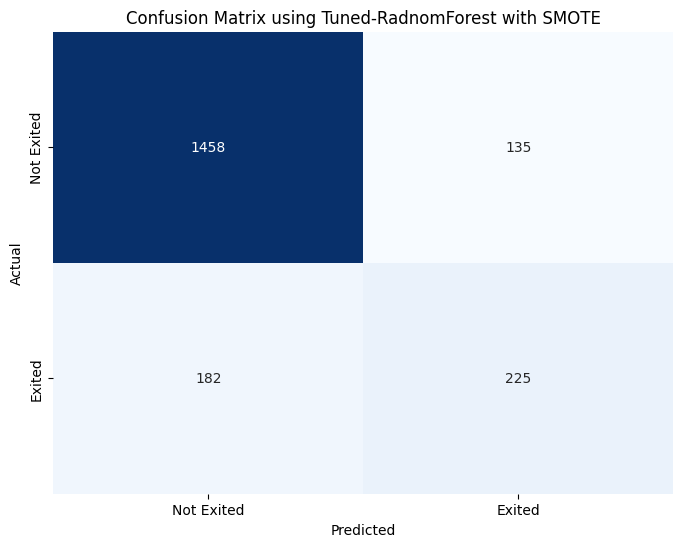

In [ ]:
## Confusion Matrix using RF with SMOTE
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_test_forest_tuned), annot=True, cbar=False,
            fmt='d', cmap='Blues', xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix using Tuned-RadnomForest with SMOTE')
plt.show()

#### **Final Comparison After Tunning Parameter**

In [ ]:
## Create lists for the f1-scores (including Tuned RF)
train_scores = [
    score_train_log,
    score_train_svc,
    score_train_svc_w,
    score_train_gauss_nb,
    score_train_knn,
    score_train_dt,
    score_train_rf,
    score_train_forest,          # RF with class weights
    score_train_bagging,
    score_train_extra,
    score_train_forest_tuned     # ✅ Tuned RF
]

test_scores = [
    score_test_log,
    score_test_svc,
    score_test_svc_w,
    score_test_gauss_nb,
    score_test_knn,
    score_test_dt,
    score_test_rf,
    score_test_forest,           # RF with class weights
    score_test_bagging,
    score_test_extra,
    score_test_forest_tuned      # ✅ Tuned RF
]

## Create model names list
model_names = [
    'Logistic Regression (SMOTE)',
    'SVC (SMOTE)',
    'SVC (Class Weights)',
    'Gaussian Naive Bayes (SMOTE)',
    'KNN (SMOTE)',
    'Decision Tree (SMOTE)',
    'Random Forest (SMOTE)',
    'Random Forest (Class Weights)',
    'Bagging Classifier (SMOTE)',
    'ExtraTrees Classifier (SMOTE)',
    'Random Forest (Tuned, SMOTE)'  # ✅ Added
]

## Create DataFrame
df_scores = pd.DataFrame({
    'Model': model_names,
    'Train f1-Score': train_scores,
    'Test f1-Score': test_scores
})

## Sort by Test f1-Score descending
df_scores = df_scores.sort_values(by='Test f1-Score', ascending=False)

## Display
print("### Model Comparison Table (Sorted by Test f1-Score):")
display(df_scores)

### Model Comparison Table (Sorted by Test f1-Score):


,Model,Train f1-Score,Test f1-Score
6,Random Forest (SMOTE),1.000000,0.591978
10,"Random Forest (Tuned, SMOTE)",0.663421,0.586701
1,SVC (SMOTE),0.721860,0.585534
7,Random Forest (Class Weights),0.602249,0.585117
8,Bagging Classifier (SMOTE),1.000000,0.558824
9,ExtraTrees Classifier (SMOTE),1.000000,0.557940
2,SVC (Class Weights),0.539209,0.531469
4,KNN (SMOTE),0.739521,0.511202
5,Decision Tree (SMOTE),1.000000,0.500579
3,Gaussian Naive Bayes (SMOTE),0.513478,0.486322


In [ ]:
## Tuned Random Forest is outperforming the whole other models --> Use it in Deployment :D

## Downlaod Tuned-RF-with-SMOTE which is the best
joblib.dump(forest_tuned, os.path.join(ASSETS_FOLDER_PATH, 'Tuned-RF-with-SMOTE.pkl'))

['/content/assets/Tuned-RF-with-SMOTE.pkl']

In [ ]:
ASSETS_FOLDER_PATH

'/content/../assets'